In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
import seaborn as sn
import pickle
import scipy.sparse as sp
from scipy.optimize import least_squares
import datetime
import lmfit
from sklearn import metrics
import math
from shapely.wkt import loads as load_wkt
import seaborn as sns

# Import Data and preprocessing

In [2]:
#################
# Load datasets #
#################

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures'

root_base = root_results+'/Base Network'

# Load LSCC
root_lscc = root_base+'/base_network_lscc.npz'
with open(root_lscc, 'rb') as handle:
        lscc_dict = pickle.load(handle)
        
##############################
# Generate DiGraph from data #
##############################

lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)
lscc_nodes = list(lscc.nodes())
n_nodes = len(lscc_nodes)

# Store node numbers
node_numbers = {i : lscc_nodes[i] for i in range(n_nodes)}

# Load geom_dict
root_geom_dict = root_base+'/base_geom_dict.pickle'
with open(root_geom_dict, 'rb') as handle:
        geom_dict = pickle.load(handle)
# Geom dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
A_LSCC_array = A_LSCC.toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

# Subtract self-loops
B_LSCC_array = A_LSCC - np.diag(np.diag(A_LSCC.toarray()))
B_LSCC = sp.csr_matrix(B_LSCC_array)

# Import NUTS shape files
root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data/'
root_map = root_data+'/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

# Get NUTS2
gdf_NUTS2 = gdf_NUTS3.copy()
gdf_NUTS2['nuts'] = [gdf_NUTS2['nuts'][i][:4] for i in range(179)]
gdf_NUTS2 = gdf_NUTS2.dissolve(by='nuts')

# Get NUTS1
gdf_NUTS1 = gdf_NUTS3.copy()
gdf_NUTS1['nuts'] = [gdf_NUTS1['nuts'][i][:3] for i in range(179)]
gdf_NUTS1 = gdf_NUTS1.dissolve(by='nuts')

# Load NUTS3 data
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results/'
root_NUTS3_base = root_results+'/NUTS1_Base/'+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3_base)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)

second_max_rule = np.argsort(X, axis=1)
second_max_rule = second_max_rule[:,-2]

print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}
quadkey_second_NUTS3 = {quadkeys[i] : second_max_rule[i] for i in range(df_NUTS.shape[0])}


# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[list(lscc.nodes())[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

NUTS3_dict_no = {df_NUTS.columns[1:][i] : i for i in range(len(df_NUTS.columns[1:]))}

Shape of NUTS3 data: (5436, 180)
The max is obtained in average with: 0.93
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


In [3]:
# sotre the dictionary of NUTS3 numbers 
root5 = root_results + '/NUTS3_graph' + '/NUTS3_dict_no.pkl'
with open(root5, 'wb') as handle:
    pickle.dump(NUTS3_dict_no, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
###############
# Import data #
###############


# import base lscc's for each network
root_base = root_results+'/NUTS1_Base/'
with open(root_base+'/NUTS1_base_networks_lscc.npz', 'rb') as handle:
        NUTS1_networks_lscc = pickle.load(handle)


root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'

df = pd.read_csv(root_results+'/Timeseries/FilteredDataFrame')
# Converting the quadkeys to strings
df['start_quadkey'] = df['start_quadkey'].astype(str)
df['end_quadkey'] = df['end_quadkey'].astype(str)
# adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

# Replace nan by 0
df = df.fillna(0)

###########################
# Get dates of timeseries #
###########################

# Get start and end dates
start_date = df.columns.values[2][:10]
end_date = df.columns.values[-1][:10]

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date
n_days = len(days)
days_dm = np.asarray([str(days[i])[5:] for i in range(n_days)])
days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
weeks = np.arange(days_week.min(),days_week.max())

# Store lockdown-date
lockdown_date = pd.to_datetime('20200324', format='%Y%m%d', errors='ignore')
lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]

# Store second lockdown-date
second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(days == second_lockdown_date).flatten()[0]

df2 = df.copy()

#ids of NUTS1, 2 and 3 for all quadkeys

NUTS3_id_start = np.asarray([quadkey_NUTS3[df2['start_quadkey'][i]] for i in range(df2.shape[0])])
NUTS2_id_start = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_start[i]]]] for i in range(df2.shape[0])])
NUTS1_id_start = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_start[i]]]] for i in range(df2.shape[0])])

NUTS3_id_end = np.asarray([quadkey_NUTS3[df2['end_quadkey'][i]] for i in range(df2.shape[0])])
NUTS2_id_end = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_end[i]]]] for i in range(df2.shape[0])])
NUTS1_id_end = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_end[i]]]] for i in range(df2.shape[0])])

df3 = df2.copy()
NUTS3_id_start = np.asarray([quadkey_NUTS3[df3['start_quadkey'][i]] for i in range(df3.shape[0])])
NUTS2_id_start = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_start[i]]]] for i in range(df3.shape[0])])
NUTS1_id_start = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_start[i]]]] for i in range(df3.shape[0])])

NUTS3_id_end = np.asarray([quadkey_NUTS3[df3['end_quadkey'][i]] for i in range(df3.shape[0])])
NUTS2_id_end = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_end[i]]]] for i in range(df3.shape[0])])
NUTS1_id_end = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_end[i]]]] for i in range(df3.shape[0])])

#insert start and end NUTS3 only

df3.insert(0,'start_NUTS3',NUTS3_id_start)
df3.insert(1,'end_NUTS3',NUTS3_id_end)

# dictionary of NUTS3 numbers
NUTS3_dict_no = { df_NUTS.columns[1:][i] : i for i in range(len(df_NUTS.columns[1:]))}

### Mancheste&Lancanshire + London NUTS

In [5]:
# NUTS3 regions corresponding to Greater Manchester, Lancashire and Greater London

manchester_area_NUTS3 = ['UKD33','UKD34','UKD35','UKD36','UKD37']
lancanshire_NUTS3 = ['UKD41','UKD42','UKD44','UKD45','UKD46','UKD47']# Liverpool region'UKD71','UKD72','UKD73','UKD74']
london_NUTS3 = ['UKI31','UKI32','UKI33','UKI34','UKI41','UKI42','UKI43',
                'UKI44','UKI45','UKI51','UKI52','UKI53','UKI54','UKI61','UKI62',
                'UKI63','UKI71','UKI72','UKI73','UKI74','UKI75']

#convert them to numbers from the dictionary
manchester_area_NUTS3_no = [NUTS3_dict_no[manchester_area_NUTS3[i]] for i in range(len(manchester_area_NUTS3))]
lancanshire_NUTS3_no =[NUTS3_dict_no[lancanshire_NUTS3[i]] for i in range(len(lancanshire_NUTS3))]
#merge lancashire and manchester
manlan_NUTS3_no = manchester_area_NUTS3_no + lancanshire_NUTS3_no
london_NUTS3_no =[NUTS3_dict_no[london_NUTS3[i]] for i in range(len(london_NUTS3))]


In [6]:
# NUTS3 of London that do not have any tiles assigned
for i in london_NUTS3_no:
    if i not in list(df3['start_NUTS3']):
        print('No tile is assigned to NUTS {}'.format(i))

No tile is assigned to NUTS 7
No tile is assigned to NUTS 57
No tile is assigned to NUTS 101


### Assigning Tiles to the 3 missing London NUTS3 using second and third max rules

In [7]:
# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule_sort = np.argsort(X, axis=1)
second_max_rule = max_rule_sort[:,-2]
third_max_rule = max_rule_sort[:,-3]

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_second_NUTS3 = {quadkeys[i] : second_max_rule[i] for i in range(df_NUTS.shape[0])}
quadkey_third_NUTS3 = {quadkeys[i] : third_max_rule[i] for i in range(df_NUTS.shape[0])}

#copy df3
df5 = df3.copy()

#second max NUTS3
second_NUTS3_id_start = np.asarray([quadkey_second_NUTS3[df5['start_quadkey'][i]] for i in range(df5.shape[0])])
second_NUTS3_id_end = np.asarray([quadkey_second_NUTS3[df5['end_quadkey'][i]] for i in range(df5.shape[0])])

#third max NUTS3
third_NUTS3_id_start = np.asarray([quadkey_third_NUTS3[df5['start_quadkey'][i]] for i in range(df5.shape[0])])
third_NUTS3_id_end = np.asarray([quadkey_third_NUTS3[df5['end_quadkey'][i]] for i in range(df5.shape[0])])

#insert the second and third start and end NUTS3 regions into data frame as new columns
df5.insert(0,'start_second_NUTS3',second_NUTS3_id_start)
df5.insert(1,'end_second_NUTS3',second_NUTS3_id_end)

df5.insert(0,'start_third_NUTS3',third_NUTS3_id_start)
df5.insert(1,'end_third_NUTS3',third_NUTS3_id_end)

In [8]:
print( 'NUTS3 number 7 in second NUTS3 = ',7 in list(df5['start_second_NUTS3']))
print( 'NUTS3 number 57 in second NUTS3 = ',57 in list(df5['start_second_NUTS3']))
print( 'NUTS3 number 101 in second NUTS3 = ',101 in list(df5['start_second_NUTS3']))

NUTS3 number 7 in second NUTS3 =  False
NUTS3 number 57 in second NUTS3 =  True
NUTS3 number 101 in second NUTS3 =  True


So NUTS3 '7' still has no tiles with second max rule

In [9]:
print( '7 in third NUTS3 = ',7 in list(df5['start_third_NUTS3']))

7 in third NUTS3 =  True


So tiles with second_NUTS 57 and 101 will be copied so that their NUTS are 57 and 101.

And tiles with third_NUTS 7 will be copied so that their NUTS is 7

In [10]:
# get quadkeys corresponding to the 3 missing NUTS3 regions
df_tmp7 = []

# NUTS3 number 7
df_tmp_start = df5.loc[(df5['start_third_NUTS3']==7)]
quadkeys_NUTS3_7 = df_tmp_start['start_quadkey'].unique()
print('Quadkeys corresponding to NUTS3 no 7 = ',list(quadkeys_NUTS3_7))

# NUTS3 number 57
df_tmp_start = df5.loc[(df5['start_second_NUTS3']==57)]
quadkeys_NUTS3_57 = df_tmp_start['start_quadkey'].unique()
print('Quadkeys corresponding to NUTS3 no 57 = ',list(quadkeys_NUTS3_57))

# NUTS3 number 101
df_tmp_start = df5.loc[(df5['start_second_NUTS3']==101)]
quadkeys_NUTS3_101= df_tmp_start['start_quadkey'].unique()
print('Quadkeys corresponding to NUTS3 no 101 = ',list(quadkeys_NUTS3_101))

df5 = df5.drop(['start_third_NUTS3','end_third_NUTS3','start_second_NUTS3','end_second_NUTS3'],axis =1)
# df_tmp_start['start_NUTS3'] = df_tmp_start['start_third_NUTS3']
# df_tmp_start = df_tmp_start.drop(['start_third_NUTS3','end_third_NUTS3','start_second_NUTS3','end_second_NUTS3'],axis =1)
# df_tmp7.append(df_tmp_start)

Quadkeys corresponding to NUTS3 no 7 =  ['031313131103', '031313131112', '031313131130']
Quadkeys corresponding to NUTS3 no 57 =  ['031313131121', '031313131123', '031313131130', '031313131132']
Quadkeys corresponding to NUTS3 no 101 =  ['031313131113', '031313131131']


### Create 2 separate dataframes for Manhester&Lancashire merged and for London

In [12]:
#
df3 = df5.copy()

df_manlan_tmp = [] # Greater Manchester + Lancashire
df_london_tmp = [] # Greater London
for i in manlan_NUTS3_no:
    df_tmp = df3.loc[(df3['start_NUTS3'] == i)]
    df_manlan_tmp.append(df_tmp)
for i in london_NUTS3_no:
    df_tmp = df3.loc[(df3['start_NUTS3'] == i) ]
    df_london_tmp.append(df_tmp)
df_manlan_tmp = pd.concat(df_manlan_tmp)  
df_london_tmp = pd.concat(df_london_tmp)

print(len(df_london_tmp['start_NUTS3'].unique()))

df_manlan = [] # Manchester Region + Lancashire
df_london = [] # London
for i in manlan_NUTS3_no:
    df_tmp = df_manlan_tmp.loc[(df_manlan_tmp['end_NUTS3'] == i)]
    df_manlan.append(df_tmp)
df_manlan = pd.concat(df_manlan)

for i in london_NUTS3_no:
    df_tmp = df_london_tmp.loc[(df_london_tmp['end_NUTS3'] == i)]
    df_london.append(df_tmp)
df_london = pd.concat(df_london)

18


In [13]:
# import networks of lscc daily evolution
root4 = root_results+'/Timeseries'+'/timeseries_daily_digraphs_lscc.pkl'
with open(root4, 'rb') as handle:
    timeseries_daily_digraphs_lscc = pickle.load(handle)

#get the dates
dates =df3.columns[4:]
dates = dates[0::3]
#remove day of week and hour
dates = [dates[i][:10] for i in range(len(dates))]

# compute adjacency matrices
adjacency_matrices = [nx.adjacency_matrix(timeseries_daily_digraphs_lscc[i]) for i in range(len(timeseries_daily_digraphs_lscc))]


## Degree change study

In [14]:
# create dataframe with evolution of degree for each quadkey
n_nodes = len(timeseries_daily_digraphs_lscc[0])
degrees_df = pd.DataFrame({'nodes':timeseries_daily_digraphs_lscc[0].nodes})
degrees = []
for i,G in enumerate(timeseries_daily_digraphs_lscc):
    daily_degree = np.asarray(list(dict(G.out_degree()).values()))
    degrees_df[dates[i]] = daily_degree
nodes = degrees_df['nodes']

In [15]:
#adding NUTS3 7 57 and 101 from average results of keys in the surroundings

# NUTS3 7
df_tmp_7 = []
for i in quadkeys_NUTS3_7:
    df_tmp_7.append(degrees_df.loc[degrees_df['nodes']==i])
df_tmp_7 = pd.concat(df_tmp_7)
#df_tmp_7 = df_tmp_7.drop(['NUTS3','nodes'],axis = 1)
df_tmp_7 = pd.DataFrame(df_tmp_7.mean()).transpose()
df_tmp_7 = df_tmp_7.rename(index={0:7})


# NUTS3 57
df_tmp_57 = []
for i in quadkeys_NUTS3_57:
    df_tmp_57.append(degrees_df.loc[degrees_df['nodes']==i])
df_tmp_57 = pd.concat(df_tmp_57)
#df_tmp_57 = df_tmp_57.drop(['NUTS3','nodes'],axis = 1)
df_tmp_57 = pd.DataFrame(df_tmp_57.mean()).transpose()
df_tmp_57 = df_tmp_57.rename(index={0:57})


# NUTS3 101
df_tmp_101 = []
for i in quadkeys_NUTS3_101:
    df_tmp_101.append(degrees_df.loc[degrees_df['nodes']==i])
df_tmp_101 = pd.concat(df_tmp_101)
#df_tmp_101 = df_tmp_101.drop(['NUTS3','nodes'],axis = 1)
df_tmp_101 = pd.DataFrame(df_tmp_101.mean()).transpose()
df_tmp_101 = df_tmp_101.rename(index={0:101})

#concatenate together
df_tmp = [df_tmp_7,df_tmp_57,df_tmp_101]
df_tmp = pd.concat(df_tmp).reset_index()
df_tmp = df_tmp.rename(columns = {'index':'NUTS3'})


In [16]:
# append the new nodes to the whole of the dataframe
degrees_NUTS3_id_start = np.asarray([quadkey_NUTS3[degrees_df['nodes'][i]] for i in range(degrees_df.shape[0])])
degrees_df.insert(0,'NUTS3',degrees_NUTS3_id_start)
#group by NUTS3 region and compute mean
degrees_df = degrees_df.groupby('NUTS3').mean() 
degrees_df = degrees_df.reset_index()
#concatenate together
degrees_df = [degrees_df,df_tmp] 
degrees_df = pd.concat(degrees_df)

In [17]:
# store median degree as a csv
degrees_df = degrees_df.reset_index(drop = True)
degrees_df_c = degrees_df.copy()
degrees_df = degrees_df.drop(columns=['NUTS3', 'nodes'])
degree_median = np.median(degrees_df,axis=0)
degree_median_df = pd.DataFrame(degree_median)
degree_median_df.to_csv(root_results+'/degree_median.csv')
degrees_df = degrees_df_c

In [18]:
#create two separate dataframes for the two regions in study
#with means of degrees of all quadkeys in those regions

# Manchester and Lancashire dataframe
degrees_manlan_df = []
for i in manlan_NUTS3_no:
    degrees_manlan_df.append(degrees_df.loc[degrees_df['NUTS3']==i])
degrees_manlan_df = pd.concat(degrees_manlan_df)
degrees_manlan_df = degrees_manlan_df.reset_index(drop = True)

#London dataframe
degrees_london_df = []
for i in london_NUTS3_no:
    degrees_london_df.append(degrees_df.loc[degrees_df['NUTS3']==i])
degrees_london_df = pd.concat(degrees_london_df)
degrees_london_df = degrees_london_df.reset_index(drop = True)

In [19]:
degrees_df

,NUTS3,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,...,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,nodes
0,0,35.666667,36.000000,36.000000,33.333333,20.000000,17.000000,34.666667,34.666667,32.000000,...,13.333333,28.333333,29.666667,31.000000,29.333333,28.000000,16.666667,13.000000,31.666667,NaN
1,1,14.200000,14.200000,14.333333,13.666667,8.800000,6.666667,14.333333,14.000000,13.600000,...,5.866667,11.866667,11.800000,12.200000,11.800000,11.333333,7.000000,5.800000,11.866667,NaN
2,2,6.333333,6.250000,6.041667,5.875000,3.472222,2.569444,6.069444,6.027778,5.916667,...,2.166667,4.819444,4.930556,5.125000,4.875000,4.722222,2.722222,2.083333,4.902778,NaN
3,3,32.250000,30.750000,32.000000,28.750000,18.500000,16.500000,29.750000,29.750000,28.000000,...,12.000000,25.750000,25.750000,26.750000,26.250000,24.250000,15.500000,12.000000,26.250000,NaN
4,4,54.000000,55.000000,55.000000,54.000000,41.000000,34.000000,52.000000,52.000000,52.000000,...,27.000000,45.000000,47.000000,51.000000,46.000000,45.000000,38.000000,29.000000,46.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,177,8.433333,8.200000,8.233333,8.133333,5.600000,4.300000,7.933333,8.200000,7.800000,...,3.833333,7.066667,7.200000,7.366667,7.266667,7.033333,4.833333,3.866667,6.933333,NaN
169,178,4.925000,4.825000,4.750000,4.400000,2.425000,1.850000,4.725000,4.700000,4.650000,...,1.475000,3.575000,3.650000,3.750000,3.575000,3.125000,1.875000,1.575000,3.650000,NaN
170,7,178.666667,183.333333,175.333333,160.666667,92.333333,76.666667,153.666667,128.666667,114.333333,...,40.333333,93.666667,97.000000,100.333333,98.000000,95.000000,53.000000,41.333333,95.333333,1.043771e+34
171,57,93.500000,96.750000,91.750000,86.250000,54.750000,46.250000,86.000000,76.750000,70.000000,...,30.500000,61.750000,63.000000,63.250000,63.000000,62.250000,40.750000,31.500000,61.500000,7.828283e+45


In [20]:
# tiers start and end dates
tiers_start_date = '2020-10-07'
tiers_end_date = '2020-11-10'

# take subdataframes corresponding to tier dates
tier_days = pd.date_range(start=tiers_start_date, end=tiers_end_date).date
n_tier_days = len(tier_days)
tier_days_dm = np.asarray([str(tier_days[i])[5:] for i in range(n_tier_days)])

#store dates of tier starting and ending in the two regions
tiers_start_date_loc_manlan = degrees_manlan_df.columns.get_loc(tiers_start_date)
tiers_end_date_loc_manlan = degrees_manlan_df.columns.get_loc(tiers_end_date)
tiers_start_date_loc_london = degrees_london_df.columns.get_loc(tiers_start_date)
tiers_end_date_loc_london = degrees_london_df.columns.get_loc(tiers_end_date)

#splitting dataframes to include only dates we are interested in
df_degrees_tier_month_manlan = degrees_manlan_df.iloc[:,tiers_start_date_loc_manlan:tiers_end_date_loc_manlan]
df_degrees_tier_month_london = degrees_london_df.iloc[:,tiers_start_date_loc_london:tiers_end_date_loc_london]

#define second lockdown date again
second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(days == second_lockdown_date).flatten()[0]


In [21]:
# compute baseline values
manlan_baseline = degrees_manlan_df.mean()[1]
london_baseline = degrees_london_df.mean()[1]

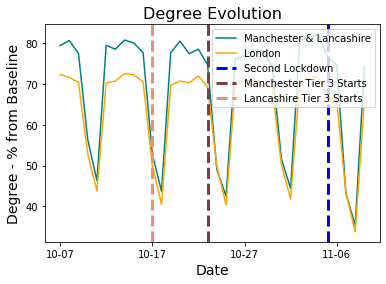

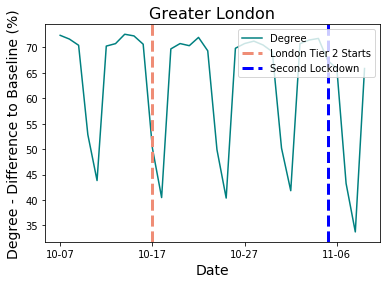

In [22]:
#plot evolution of degree in both regions

n_days = df_degrees_tier_month_manlan.shape[1]
x_days = np.arange(n_days)

second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(tier_days == second_lockdown_date).flatten()[0]

manchester_tier_lockdown_date = pd.to_datetime('20201023', format='%Y%m%d', errors='ignore')
manchester_tier_lockdown_date_number = np.argwhere(tier_days == manchester_tier_lockdown_date).flatten()[0]

lancashire_tier_lockdown_date = pd.to_datetime('20201017', format='%Y%m%d', errors='ignore')
lancashire_tier_lockdown_date_number = np.argwhere(tier_days == lancashire_tier_lockdown_date).flatten()[0]

london_tier_lockdown_date = pd.to_datetime('20201017', format='%Y%m%d', errors='ignore')
london_tier_lockdown_date_number = np.argwhere(tier_days == london_tier_lockdown_date).flatten()[0]


fig,ax = plt.subplots(1)

plt.plot(x_days,100*df_degrees_tier_month_manlan.mean()/manlan_baseline,color = 'teal',label = 'Manchester & Lancashire')
plt.plot(x_days,100*df_degrees_tier_month_london.mean()/london_baseline,color = 'orange',label = 'London')

ticks = range(0,n_days,10)
ax.set(xticks = ticks, xticklabels = tier_days_dm[ticks],
      xlabel = 'Date')
ax.set_title('Degree Evolution',fontsize = 16)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.axvline(x = manchester_tier_lockdown_date_number,linestyle='dashed', 
           color = '#7E3E41',label = 'Manchester Tier 3 Starts',linewidth=3)
ax.axvline(x = lancashire_tier_lockdown_date_number, linestyle='dashed',
           color = '#EF8D76',label = 'Lancashire Tier 3 Starts',linewidth=3)

ax.legend(loc = 1)
ax.set_xlabel('Date',fontsize = 14)
ax.set_ylabel('Degree - % from Baseline',fontsize = 14)


fig.savefig(root_figure+'/metropolitan'+'/manlan_weeks_degree.pdf', dpi=fig.dpi,bbox_inches='tight')

fig,ax = plt.subplots(1)
plt.plot(x_days,100*df_degrees_tier_month_london.mean()/london_baseline,color = 'teal',label = 'Degree')
ticks = range(0,n_days,10)
ax.set(xticks = ticks, xticklabels = tier_days_dm[ticks])
ax.set_xlabel('Date',fontsize = 14)
ax.set_ylabel('Degree - Difference to Baseline (%)',fontsize = 14)
ax.set_title('Greater London',fontsize = 16)
ax.axvline(x = london_tier_lockdown_date_number, linestyle='dashed',linewidth=3,
           color = '#EF8D76',label = 'London Tier 2 Starts')
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)

ax.legend(loc = 1)
fig.savefig(root_figure+'/metropolitan'+'/london_weeks_degree.pdf', dpi=fig.dpi,bbox_inches='tight')


### London to Tier 2 and Lancashire to Tier 3

In [23]:
#baseline and post-tier dates

baseline_sunday = '2020-10-11'
baseline_wednesday = '2020-10-14'

post_tier_sunday = '2020-10-18'
post_tier_wednesday = '2020-10-21'

# take those dates in the dataframe and compute relative difference to baseline, for both regions

degrees_change_london_df = degrees_london_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]
degrees_change_manlan_df = degrees_manlan_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]

#relative difference for regions in London
degrees_change_london_df['degree_sunday_change'] = 100*(1-degrees_change_london_df[post_tier_sunday]/degrees_change_london_df[baseline_sunday])
degrees_change_london_df['degree_wednesday_change'] = 100*(1-degrees_change_london_df[post_tier_wednesday]/degrees_change_london_df[baseline_wednesday])

#relative difference for regions in Manchester and Lancashire
degrees_change_manlan_df['degree_sunday_change'] = 100*(1-degrees_change_manlan_df[post_tier_sunday]/degrees_change_manlan_df[baseline_sunday])
degrees_change_manlan_df['degree_wednesday_change'] = 100*(1-degrees_change_manlan_df[post_tier_wednesday]/degrees_change_manlan_df[baseline_wednesday])



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [24]:
#rename columns
degrees_change_manlan_df = degrees_change_manlan_df.rename(columns={'NUTS3': 'nuts_no'})
degrees_change_london_df = degrees_change_london_df.rename(columns={'NUTS3': 'nuts_no'})

#root to read geodataframe containing NUTS3 regions shapes
root4 = root_results + '/NUTS3_graph' + '/gdf_NUTS3.shp'
gdf_NUTS3 = gpd.read_file(root4)
gdf_NUTS3_results = pd.read_csv(root_results+'/NUTS3_graph'+'/gdf_NUTS3_results.csv')

#merge with the results we had and rename columns
gdf_NUTS3_results = pd.merge(gdf_NUTS3,gdf_NUTS3_results,how = 'inner', on = 'nuts')
gdf_NUTS3_results = gdf_NUTS3_results.drop(['geometry_y','Unnamed: 0'],axis = 1)
gdf_NUTS3_results = gdf_NUTS3_results.rename(columns={'geometry_x':'geometry'})

In [25]:
# merge the geopandas dataframe with the change dataframes with degrees differences
gdf_NUTS3_results_manlan_degree = pd.merge(gdf_NUTS3_results,degrees_change_manlan_df, how="inner", on=["nuts_no"])
gdf_NUTS3_results_london_degree = pd.merge(gdf_NUTS3_results,degrees_change_london_df, how="inner", on=["nuts_no"])

### Manchester to Tier 3

In [26]:
%%capture
# baseline and post-tier dates
baseline_sunday = '2020-10-18'
baseline_wednesday = '2020-10-21'

post_tier_sunday = '2020-10-25'
post_tier_wednesday = '2020-10-28'

# same as above, but this time compute difference for when Manchester enters tier 3. 
# London is not really necessary here

degrees_change_london_df = degrees_london_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]
degrees_change_manlan_df = degrees_manlan_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]

degrees_change_london_df['man_degree_sunday_change'] = 100*(1-degrees_change_london_df[post_tier_sunday]/degrees_change_london_df[baseline_sunday])
degrees_change_london_df['man_degree_wednesday_change'] = 100*(1-degrees_change_london_df[post_tier_wednesday]/degrees_change_london_df[baseline_wednesday])

degrees_change_manlan_df['man_degree_sunday_change'] = 100*(1-degrees_change_manlan_df[post_tier_sunday]/degrees_change_manlan_df[baseline_sunday])
degrees_change_manlan_df['man_degree_wednesday_change'] = 100*(1-degrees_change_manlan_df[post_tier_wednesday]/degrees_change_manlan_df[baseline_wednesday])



In [27]:
# rename columns and merge with previous geodataframe
degrees_change_manlan_df = degrees_change_manlan_df.rename(columns={'NUTS3': 'nuts_no'})
degrees_change_london_df = degrees_change_london_df.rename(columns={'NUTS3': 'nuts_no'})


root4 = root_results + '/NUTS3_graph' + '/gdf_NUTS3.shp'
gdf_NUTS3 = gpd.read_file(root4)

gdf_NUTS3_results = pd.read_csv(root_results+'/NUTS3_graph'+'/gdf_NUTS3_results.csv')
gdf_NUTS3_results = pd.merge(gdf_NUTS3,gdf_NUTS3_results,how = 'inner', on = 'nuts')
gdf_NUTS3_results = gdf_NUTS3_results.drop(['geometry_y','Unnamed: 0'],axis = 1)
gdf_NUTS3_results = gdf_NUTS3_results.rename(columns={'geometry_x':'geometry'})

gdf_NUTS3_results_manlan_degree = pd.merge(gdf_NUTS3_results_manlan_degree,degrees_change_manlan_df, how="inner", on=["nuts_no"])
gdf_NUTS3_results_london_degree = pd.merge(gdf_NUTS3_results_london_degree,degrees_change_london_df, how="inner", on=["nuts_no"])


# Change in radius of gyration

In [28]:
#read csv with stored radius of gyrations of tiles in LSCC
root4 = root_results + '/Timeseries' +'/radius_of_gyration_lscc.csv' 
r_total_nodal_df = pd.read_csv(root4)
r_total_nodal_df = r_total_nodal_df.rename(columns = {'Unnamed: 0':'nodes'})

In [29]:
# manipulate dataframe of radius of gyration of tiles
r_total_nodal_df = r_total_nodal_df.set_index('nodes')
rg_df = r_total_nodal_df
col_names = [dates[i] for i in range(266)]
rg_df.columns = col_names 
rg_df = rg_df.reset_index()
rg_df['nodes'] = nodes

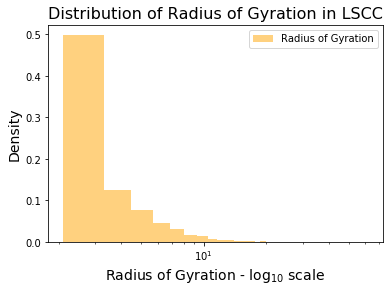

In [30]:
#plot histogram radius of gyration on the first day
fig,ax = plt.subplots(1)
plt.hist((rg_df['2020-03-10']),bins = 50,color = 'orange',label = 'Radius of Gyration',alpha = 0.5,density = True)
ax.set_xscale('log')
ax.set_title('Distribution of Radius of Gyration in LSCC',fontsize = 16)
ax.set_xlabel(r'Radius of Gyration - $\log_{10}$ scale',fontsize = 14)
ax.legend()
ax.set_ylabel('Density',fontsize = 14)
fig.savefig(root_figure + '/Base Network'+'/rg_dist.pdf',bbox_inches='tight')

#### Dataframes for both regions with evolution of radius of gyration

In [31]:
#adding NUTS3 7 57 and 101 from average results of keys in the surroundings

# NUTS3 number 7
df_tmp_7 = []
for i in quadkeys_NUTS3_7:
    df_tmp_7.append(rg_df.loc[rg_df['nodes']==i])
df_tmp_7 = pd.concat(df_tmp_7)
#df_tmp_7 = df_tmp_7.drop(['NUTS3','nodes'],axis = 1)
df_tmp_7 = pd.DataFrame(df_tmp_7.mean()).transpose()
df_tmp_7 = df_tmp_7.rename(index={0:7})

# NUTS3 number 57
df_tmp_57 = []
for i in quadkeys_NUTS3_57:
    df_tmp_57.append(rg_df.loc[rg_df['nodes']==i])
df_tmp_57 = pd.concat(df_tmp_57)
#df_tmp_57 = df_tmp_57.drop(['NUTS3','nodes'],axis = 1)
df_tmp_57 = pd.DataFrame(df_tmp_57.mean()).transpose()
df_tmp_57 = df_tmp_57.rename(index={0:57})

# NUTS3 number 101
df_tmp_101 = []
for i in quadkeys_NUTS3_101:
    df_tmp_101.append(rg_df.loc[rg_df['nodes']==i])
df_tmp_101 = pd.concat(df_tmp_101)
#df_tmp_101 = df_tmp_101.drop(['NUTS3','nodes'],axis = 1)
df_tmp_101 = pd.DataFrame(df_tmp_101.mean()).transpose()
df_tmp_101 = df_tmp_101.rename(index={0:101})

# concatenate them
df_tmp = [df_tmp_7,df_tmp_57,df_tmp_101]
df_tmp = pd.concat(df_tmp).reset_index()
df_tmp = df_tmp.rename(columns = {'index':'NUTS3'})


In [32]:
# concatenate them with main dataframe
rg_NUTS3_id_start = np.asarray([quadkey_NUTS3[rg_df['nodes'][i]] for i in range(rg_df.shape[0])])
rg_df.insert(0,'NUTS3',rg_NUTS3_id_start)
rg_df = rg_df.groupby('NUTS3').mean()
rg_df = rg_df.reset_index()
rg_df = [rg_df,df_tmp]
rg_df = pd.concat(rg_df)
rg_df = rg_df.reset_index(drop = True)

In [33]:
#create separate dataframes for the two metropolitan areas
rg_manlan_df = []
for i in manlan_NUTS3_no:
    rg_manlan_df.append(rg_df.loc[rg_df['NUTS3']==i])
rg_manlan_df = pd.concat(rg_manlan_df)
rg_manlan_df = rg_manlan_df.reset_index(drop = True)

rg_london_df = []
for i in london_NUTS3_no:
    rg_london_df.append(rg_df.loc[rg_df['NUTS3']==i])
rg_london_df = pd.concat(rg_london_df)
rg_london_df = rg_london_df.reset_index(drop = True)

In [34]:
# start and end tier dates
tiers_start_date = '2020-10-07'
tiers_end_date = '2020-11-10'

tier_days = pd.date_range(start=tiers_start_date, end=tiers_end_date).date
n_tier_days = len(tier_days)
tier_days_dm = np.asarray([str(tier_days[i])[5:] for i in range(n_tier_days)])


tiers_start_date_loc_manlan = rg_manlan_df.columns.get_loc(tiers_start_date)
tiers_end_date_loc_manlan = rg_manlan_df.columns.get_loc(tiers_end_date)

tiers_start_date_loc_london = rg_london_df.columns.get_loc(tiers_start_date)
tiers_end_date_loc_london = rg_london_df.columns.get_loc(tiers_end_date)

df_rg_tier_month_manlan = rg_manlan_df.iloc[:,tiers_start_date_loc_manlan:tiers_end_date_loc_manlan]
df_rg_tier_month_london = rg_london_df.iloc[:,tiers_start_date_loc_london:tiers_end_date_loc_london]

#second lockdown date
second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(days == second_lockdown_date).flatten()[0]


In [35]:
#baseline values
manlan_baseline =rg_manlan_df.mean()[1]
london_baseline =rg_london_df.mean()[1] 

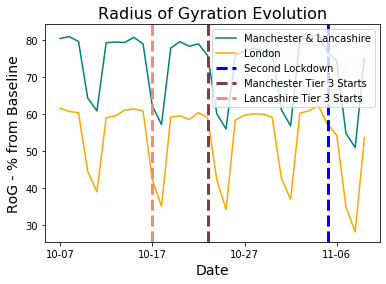

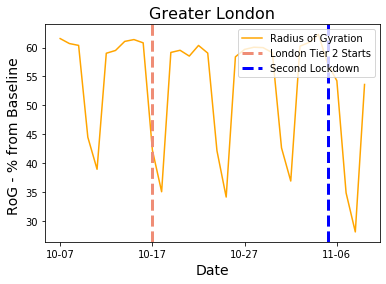

In [36]:
#plot evolution in that timeframe
n_days = df_rg_tier_month_manlan.shape[1]
x_days = np.arange(n_days)

second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(tier_days == second_lockdown_date).flatten()[0]

manchester_tier_lockdown_date = pd.to_datetime('20201023', format='%Y%m%d', errors='ignore')
manchester_tier_lockdown_date_number = np.argwhere(tier_days == manchester_tier_lockdown_date).flatten()[0]

lancashire_tier_lockdown_date = pd.to_datetime('20201017', format='%Y%m%d', errors='ignore')
lancashire_tier_lockdown_date_number = np.argwhere(tier_days == lancashire_tier_lockdown_date).flatten()[0]

london_tier_lockdown_date = pd.to_datetime('20201017', format='%Y%m%d', errors='ignore')
london_tier_lockdown_date_number = np.argwhere(tier_days == london_tier_lockdown_date).flatten()[0]


fig,ax = plt.subplots(1)
plt.plot(x_days,100*df_rg_tier_month_manlan.mean()/manlan_baseline,color = 'teal',label = 'Manchester & Lancashire')
plt.plot(x_days,100*df_rg_tier_month_london.mean()/london_baseline,color = 'orange',label = 'London')

ticks = range(0,n_days,10)
ax.set(xticks = ticks, xticklabels = tier_days_dm[ticks],
      xlabel = 'Date')
ax.set_title('Radius of Gyration Evolution',fontsize = 16)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.axvline(x = manchester_tier_lockdown_date_number,linestyle='dashed', 
           color = '#7E3E41',label = 'Manchester Tier 3 Starts',linewidth=3)
ax.axvline(x = lancashire_tier_lockdown_date_number, linestyle='dashed',
           color = '#EF8D76',label = 'Lancashire Tier 3 Starts',linewidth=3)

ax.legend(loc = 1)
ax.set_xlabel('Date',fontsize = 14)
ax.set_ylabel('RoG - % from Baseline',fontsize = 14)


fig.savefig(root_figure+'/metropolitan'+'/manlan_weeks.pdf', dpi=fig.dpi,bbox_inches='tight')

fig,ax = plt.subplots(1)
plt.plot(x_days,100*df_rg_tier_month_london.mean()/london_baseline,color = 'orange',label = 'Radius of Gyration')
ticks = range(0,n_days,10)
ax.set(xticks = ticks, xticklabels = tier_days_dm[ticks])
ax.set_xlabel('Date',fontsize = 14)
ax.set_ylabel('RoG - % from Baseline ',fontsize = 14)
ax.set_title('Greater London',fontsize = 16)
ax.axvline(x = london_tier_lockdown_date_number, linestyle='dashed',linewidth=3,
           color = '#EF8D76',label = 'London Tier 2 Starts')
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)

ax.legend(loc = 1)
fig.savefig(root_figure+'/metropolitan'+'/london_weeks.pdf', dpi=fig.dpi,bbox_inches='tight')


### London to tier 2 and Lancashire to tier 3

In [37]:
# baseline and post-tier dates
baseline_sunday = '2020-10-11'
baseline_wednesday = '2020-10-14'

post_tier_sunday = '2020-10-18'
post_tier_wednesday = '2020-10-21'

#compute relative changes in RoG in both metropolitan areas
rg_change_london_df = rg_london_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]
rg_change_manlan_df = rg_manlan_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]

rg_change_london_df['rg_sunday_change'] = 100*(1-rg_change_london_df[post_tier_sunday]/rg_change_london_df[baseline_sunday])
rg_change_london_df['rg_wednesday_change'] = 100*(1-rg_change_london_df[post_tier_wednesday]/rg_change_london_df[baseline_wednesday])

rg_change_manlan_df['rg_sunday_change'] = 100*(1-rg_change_manlan_df[post_tier_sunday]/rg_change_manlan_df[baseline_sunday])
rg_change_manlan_df['rg_wednesday_change'] = 100*(1-rg_change_manlan_df[post_tier_wednesday]/rg_change_manlan_df[baseline_wednesday])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [38]:
# rename columns
rg_change_manlan_df = rg_change_manlan_df.rename(columns={'NUTS3': 'nuts_no'})
rg_change_london_df = rg_change_london_df.rename(columns={'NUTS3': 'nuts_no'})

In [39]:
# import shapes of NUTS3 regions
root4 = root_results + '/NUTS3_graph' + '/gdf_NUTS3.shp'
gdf_NUTS3 = gpd.read_file(root4)

gdf_NUTS3_results = pd.read_csv(root_results+'/NUTS3_graph'+'/gdf_NUTS3_results.csv')
gdf_NUTS3_results = pd.merge(gdf_NUTS3,gdf_NUTS3_results,how = 'inner', on = 'nuts')
gdf_NUTS3_results = gdf_NUTS3_results.drop(['geometry_y','Unnamed: 0'],axis = 1)
gdf_NUTS3_results = gdf_NUTS3_results.rename(columns={'geometry_x':'geometry'})

In [40]:
#merge with the RoG results
gdf_NUTS3_results_manlan_rg = pd.merge(gdf_NUTS3_results,rg_change_manlan_df, how="inner", on=["nuts_no"])
gdf_NUTS3_results_london_rg = pd.merge(gdf_NUTS3_results,rg_change_london_df, how="inner", on=["nuts_no"])

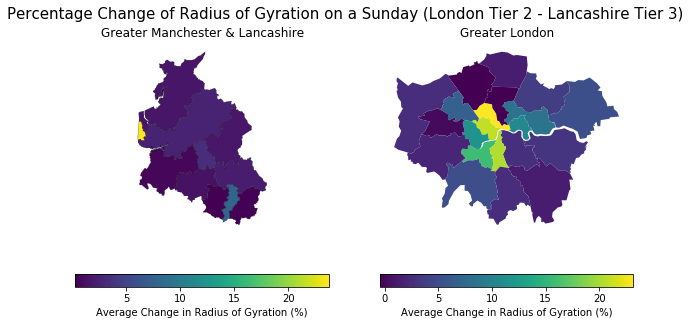

In [41]:
#plot weekend
fig,(ax1,ax2) =plt.subplots(1,2,figsize =(10,5))
#gdf_NUTS3_results_manlan_rg = gdf_NUTS3_results_manlan_rg.set_geometry('geometry')

ax1.set_axis_off()
ax1.set_axis_off()
ax1.set_title('Greater Manchester & Lancashire')
divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.2)
#a = gdf_NUTS3_results_manlan_rg.plot(linewidth=0.2, ax=ax1, column = 'sunday_change', cmap='viridis',edgecolor='0',
#                       legend = True,cax=cax)
vmin = np.min(gdf_NUTS3_results_london_rg['rg_sunday_change'])
vmax = np.max(gdf_NUTS3_results_london_rg['rg_sunday_change'])
a= gdf_NUTS3_results_manlan_rg.plot(linewidth=0.2, ax=ax1, column = 'rg_sunday_change', cmap='viridis',edgecolor='0',
                                 legend = True,
                                 legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})


#gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax[0], color = 'black',alpha = 0.1)

divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.2)


b = gdf_NUTS3_results_london_rg.plot(linewidth=0, ax=ax2, column = 'rg_sunday_change', cmap='viridis',edgecolor='0',
                                  legend = True,
                                  legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
#ax1.colorbar()
ax2.set_title('Greater London')
ax2.set_axis_off()
#gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax[1], color = 'black',alpha = 0.1)
fig.suptitle('Percentage Change of Radius of Gyration on a Sunday (London Tier 2 - Lancashire Tier 3)',fontsize = 15)

fig.savefig(root_figure+'/metropolitan'+'/first_radius_sunday.eps', dpi=fig.dpi,bbox_inches='tight')


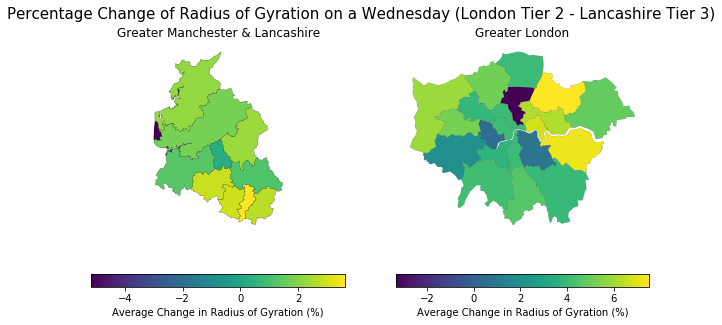

In [42]:
#plot weekday
fig,(ax1,ax2) =plt.subplots(1,2,figsize =(10,5))
#gdf_NUTS3_results_manlan_rg = gdf_NUTS3_results_manlan_rg.set_geometry('geometry')

ax1.set_axis_off()
ax1.set_axis_off()
ax1.set_title('Greater Manchester & Lancashire')
#cax = divider.append_axes("right", size="5%", pad=0.2)
#a = gdf_NUTS3_results_manlan_rg.plot(linewidth=0.2, ax=ax1, column = 'sunday_change', cmap='viridis',edgecolor='0',
#                       legend = True,cax=cax)
vmax = np.max(gdf_NUTS3_results_london_rg['rg_wednesday_change'])
vmin = np.min(gdf_NUTS3_results_london_rg['rg_wednesday_change'])
a= gdf_NUTS3_results_manlan_rg.plot(linewidth=0.2, ax=ax1, column = 'rg_wednesday_change', cmap='viridis',edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})


#gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax[0], color = 'black',alpha = 0.1)

divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.2)
vmax = np.max(gdf_NUTS3_results_manlan_rg['rg_wednesday_change'])
b = gdf_NUTS3_results_london_rg.plot(linewidth=0.1, ax=ax2, column = 'rg_wednesday_change', cmap='viridis',edgecolor='0',
                                  legend = True,
                                  legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
#ax1.colorbar()
ax2.set_title('Greater London')
ax2.set_axis_off()
fig.suptitle('Percentage Change of Radius of Gyration on a Wednesday (London Tier 2 - Lancashire Tier 3)',fontsize = 15)
fig.savefig(root_figure+'/metropolitan'+'/first_radius_wednesday.eps', dpi=fig.dpi,bbox_inches='tight')


## Manchester to tier 3

In [43]:
%%capture
#set baseline and post-tier dates to compare
baseline_sunday = '2020-10-18'
baseline_wednesday = '2020-10-21'

post_tier_sunday = '2020-10-25'
post_tier_wednesday = '2020-10-28'

#compute relative changes from baseline to post-tier values in both metropolitan areas
rg_change_london_df = rg_london_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]
rg_change_manlan_df = rg_manlan_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]

rg_change_london_df['man_rg_sunday_change'] = 100*(1-rg_change_london_df[post_tier_sunday]/rg_change_london_df[baseline_sunday])
rg_change_london_df['man_rg_wednesday_change'] = 100*(1-rg_change_london_df[post_tier_wednesday]/rg_change_london_df[baseline_wednesday])

rg_change_manlan_df['man_rg_sunday_change'] = 100*(1-rg_change_manlan_df[post_tier_sunday]/rg_change_manlan_df[baseline_sunday])
rg_change_manlan_df['man_rg_wednesday_change'] = 100*(1-rg_change_manlan_df[post_tier_wednesday]/rg_change_manlan_df[baseline_wednesday])



In [44]:
#rename columns
rg_change_manlan_df = rg_change_manlan_df.rename(columns={'NUTS3': 'nuts_no'})
rg_change_london_df = rg_change_london_df.rename(columns={'NUTS3': 'nuts_no'})

In [45]:
#import shapes
root4 = root_results + '/NUTS3_graph' + '/gdf_NUTS3.shp'
gdf_NUTS3 = gpd.read_file(root4)

gdf_NUTS3_results = pd.read_csv(root_results+'/NUTS3_graph'+'/gdf_NUTS3_results.csv')
gdf_NUTS3_results = pd.merge(gdf_NUTS3,gdf_NUTS3_results,how = 'inner', on = 'nuts')
gdf_NUTS3_results = gdf_NUTS3_results.drop(['geometry_y','Unnamed: 0'],axis = 1)
gdf_NUTS3_results = gdf_NUTS3_results.rename(columns={'geometry_x':'geometry'})

In [46]:
#merge with RoG results
gdf_NUTS3_results_manlan_rg = pd.merge(gdf_NUTS3_results_manlan_rg,rg_change_manlan_df, how="inner", on=["nuts_no"])
gdf_NUTS3_results_london_rg = pd.merge(gdf_NUTS3_results_london_rg,rg_change_london_df, how="inner", on=["nuts_no"])

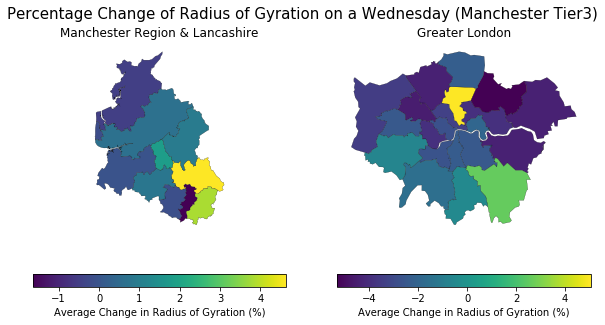

In [47]:
#plot weekday
fig,(ax1,ax2) =plt.subplots(1,2,figsize =(10,5))
#gdf_NUTS3_results_manlan_rg = gdf_NUTS3_results_manlan_rg.set_geometry('geometry')

ax1.set_axis_off()
ax1.set_axis_off()
ax1.set_title('Manchester Region & Lancashire')
#cax = divider.append_axes("right", size="5%", pad=0.2)
#a = gdf_NUTS3_results_manlan_rg.plot(linewidth=0.2, ax=ax1, column = 'sunday_change', cmap='viridis',edgecolor='0',
#                       legend = True,cax=cax)
#vmax = np.max(gdf_NUTS3_results_london_rg['rg_wednesday_change'])
#vmin = np.min(gdf_NUTS3_results_london_rg['rg_wednesday_change'])
a= gdf_NUTS3_results_manlan_rg.plot(linewidth=0.2, ax=ax1, column = 'man_rg_wednesday_change', cmap='viridis',edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})


#gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax[0], color = 'black',alpha = 0.1)

divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.2)
vmax = np.max(gdf_NUTS3_results_manlan_rg['man_rg_wednesday_change'])
b = gdf_NUTS3_results_london_rg.plot(linewidth=0.2, ax=ax2, column = 'man_rg_wednesday_change', cmap='viridis',edgecolor='0',
                                  legend = True,
                                  legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
#ax1.colorbar()
ax2.set_title('Greater London')
ax2.set_axis_off()
fig.suptitle('Percentage Change of Radius of Gyration on a Wednesday (Manchester Tier3)',fontsize = 15)
fig.savefig(root_figure+'/metropolitan'+'/second_radius_wednesday.eps', dpi=fig.dpi,bbox_inches='tight')


# NEW PLOTS

In [48]:
#coordinates for annotations
Blackpool_coordinates = (-337181.4664221865, 7101198.681374636)
Blackpool_coordinates_text = (-347181.4664221865, 7061198.681374636)

Manchester_coordinates = (-248491.003603233, 7032582.417602098)
Manchester_coordinates_text = (-258491.003603233, 7002582.417602098)


In [49]:
# changing to negative change for more intuitive visualization
gdf_NUTS3_results_london_degree['degree_sunday_change']= -gdf_NUTS3_results_london_degree['degree_sunday_change']
gdf_NUTS3_results_london_degree['degree_wednesday_change']= -gdf_NUTS3_results_london_degree['degree_wednesday_change']
gdf_NUTS3_results_london_rg['rg_sunday_change']= -gdf_NUTS3_results_london_rg['rg_sunday_change']
gdf_NUTS3_results_london_rg['rg_wednesday_change']= -gdf_NUTS3_results_london_rg['rg_wednesday_change']


gdf_NUTS3_results_manlan_degree['degree_sunday_change']= -gdf_NUTS3_results_manlan_degree['degree_sunday_change']
gdf_NUTS3_results_manlan_degree['degree_wednesday_change']= -gdf_NUTS3_results_manlan_degree['degree_wednesday_change']
gdf_NUTS3_results_manlan_degree['man_degree_sunday_change']= -gdf_NUTS3_results_manlan_degree['man_degree_sunday_change']
gdf_NUTS3_results_manlan_degree['man_degree_wednesday_change']= -gdf_NUTS3_results_manlan_degree['man_degree_wednesday_change']

gdf_NUTS3_results_manlan_rg['rg_sunday_change']= -gdf_NUTS3_results_manlan_rg['rg_sunday_change']
gdf_NUTS3_results_manlan_rg['rg_wednesday_change']= -gdf_NUTS3_results_manlan_rg['rg_wednesday_change']
gdf_NUTS3_results_manlan_rg['man_rg_sunday_change']= -gdf_NUTS3_results_manlan_rg['man_rg_sunday_change']
gdf_NUTS3_results_manlan_rg['man_rg_wednesday_change']= -gdf_NUTS3_results_manlan_rg['man_rg_wednesday_change']



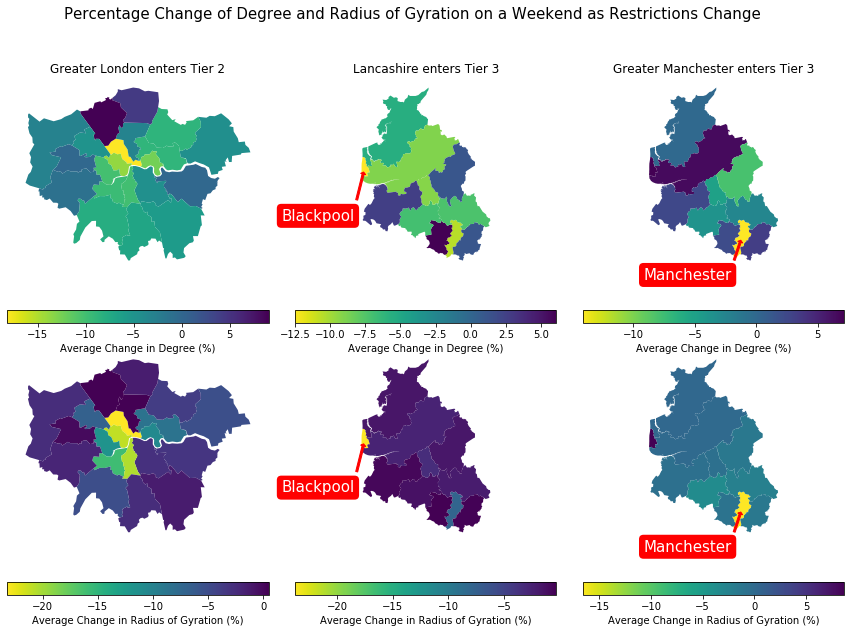

In [50]:
#plot weekend

cmap_reversed = plt.cm.get_cmap('viridis_r')
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(wspace=0.1,hspace=0)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()
ax5.set_axis_off()
ax6.set_axis_off()

gdf_NUTS3_results_london_degree.plot(linewidth=0, ax=ax1, column = 'degree_sunday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Degree (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_degree.plot(linewidth=0, ax=ax2, column = 'degree_sunday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Degree (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_degree.plot(linewidth=0, ax=ax3, column = 'man_degree_sunday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Degree (%)",'orientation': "horizontal"})
gdf_NUTS3_results_london_rg.plot(linewidth=0, ax=ax4, column = 'rg_sunday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_rg.plot(linewidth=0, ax=ax5, column = 'rg_sunday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_rg.plot(linewidth=0, ax=ax6, column = 'man_rg_sunday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})

ax1.set_title('Greater London enters Tier 2')
ax2.set_title('Lancashire enters Tier 3')
ax3.set_title('Greater Manchester enters Tier 3')

annotation2 = ax2.annotate('Blackpool', xy=Blackpool_coordinates,  xycoords='data',
            xytext=Blackpool_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            horizontalalignment='right', verticalalignment='top',
            )
annotation2.set_fontsize(15)
annotation2.set_color('white')

annotation5 = ax5.annotate('Blackpool', xy=Blackpool_coordinates,  xycoords='data',
            xytext=Blackpool_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            horizontalalignment='right', verticalalignment='top',
            )
annotation5.set_fontsize(15)
annotation5.set_color('white')

annotation3 = ax3.annotate('Manchester', xy=Manchester_coordinates,  xycoords='data',
            xytext=Manchester_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation3.set_fontsize(15)
annotation3.set_color('white')

annotation6 = ax6.annotate('Manchester', xy=Manchester_coordinates,  xycoords='data',
            xytext=Manchester_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation6.set_fontsize(15)
annotation6.set_color('white')

fig.suptitle('Percentage Change of Degree and Radius of Gyration on a Weekend as Restrictions Change',fontsize = 15)
fig.savefig(root_figure+'/metropolitan'+'/SUNDAY.eps', dpi=fig.dpi,bbox_inches='tight')



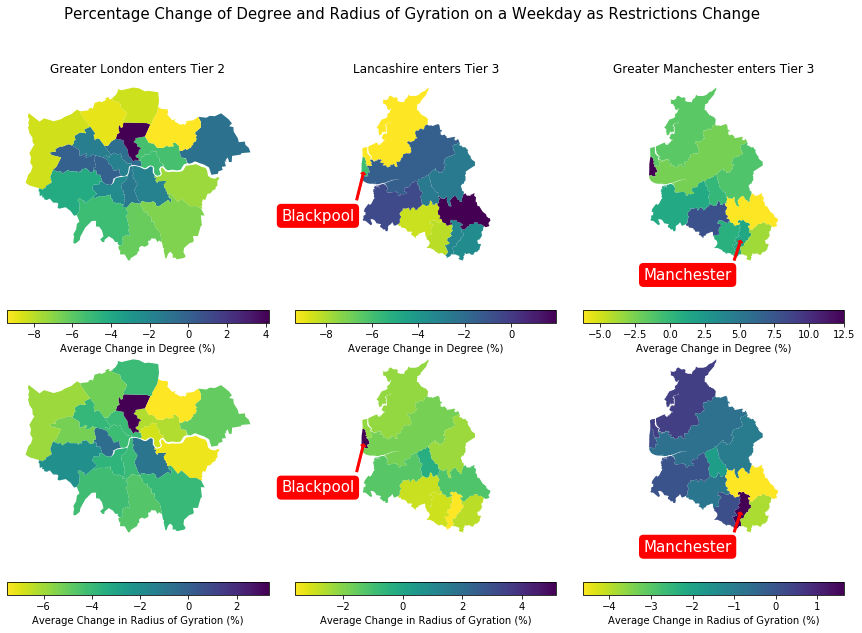

In [51]:
#plot weekday
fig = plt.figure(figsize = (15,10))
#gdf_NUTS3_results_manlan = gdf_NUTS3_results_manlan.set_geometry('geometry')
fig.subplots_adjust(wspace=0.1,hspace=0)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()
ax5.set_axis_off()
ax6.set_axis_off()


gdf_NUTS3_results_london_degree.plot(linewidth=0, ax=ax1, column = 'degree_wednesday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Degree (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_degree.plot(linewidth=0, ax=ax2, column = 'degree_wednesday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Degree (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_degree.plot(linewidth=0, ax=ax3, column = 'man_degree_wednesday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Degree (%)",'orientation': "horizontal"})
gdf_NUTS3_results_london_rg.plot(linewidth=0, ax=ax4, column = 'rg_wednesday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_rg.plot(linewidth=0, ax=ax5, column = 'rg_wednesday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_rg.plot(linewidth=0, ax=ax6, column = 'man_rg_wednesday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})



ax1.set_title('Greater London enters Tier 2')
ax2.set_title('Lancashire enters Tier 3')
ax3.set_title('Greater Manchester enters Tier 3')

annotation2 = ax2.annotate('Blackpool', xy=Blackpool_coordinates,  xycoords='data',
            xytext=Blackpool_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            horizontalalignment='right', verticalalignment='top',
            )
annotation2.set_fontsize(15)
annotation2.set_color('white')

annotation5 = ax5.annotate('Blackpool', xy=Blackpool_coordinates,  xycoords='data',
            xytext=Blackpool_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            horizontalalignment='right', verticalalignment='top',
            )
annotation5.set_fontsize(15)
annotation5.set_color('white')

annotation3 = ax3.annotate('Manchester', xy=Manchester_coordinates,  xycoords='data',
            xytext=Manchester_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation3.set_fontsize(15)
annotation3.set_color('white')

annotation6 = ax6.annotate('Manchester', xy=Manchester_coordinates,  xycoords='data',
            xytext=Manchester_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 2,headwidth=5,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation6.set_fontsize(15)
annotation6.set_color('white')

fig.suptitle('Percentage Change of Degree and Radius of Gyration on a Weekday as Restrictions Change',fontsize = 15)
fig.savefig(root_figure+'/metropolitan'+'/WEDNESDAY.eps', dpi=fig.dpi,bbox_inches='tight')


# England Map


In [52]:
degrees_df_c = rg_df.copy()
degrees_df_c = degrees_df_c.rename(columns={'NUTS3': 'nuts_no'})
degrees_df_c = degrees_df_c.drop('nuts_no', 1)
degrees_df_c = degrees_df_c.drop('nodes', 1)

# tiers start and end dates
start_date = '2020-09-01'
end_date = '2020-11-05'

start_date = degrees_df_c.columns.get_loc(start_date)
end_date = degrees_df_c.columns.get_loc(end_date)

degrees_df_c = degrees_df_c.iloc[:,start_date:end_date]
m = degrees_df_c.mean(axis = 0)

In [53]:
# baseline and post-tier dates
baseline_sunday = '2020-09-13'
baseline_wednesday = '2020-09-09'

post_tier_sunday = '2020-10-25'
post_tier_wednesday = '2020-10-28'

In [54]:
degree_national_df = rg_df[['NUTS3',baseline_sunday,baseline_wednesday,post_tier_sunday,post_tier_wednesday]]

In [55]:
%%capture
degree_national_df['wednesday_change'] = 100*degree_national_df[post_tier_wednesday]/degree_national_df[baseline_wednesday]-100
degree_national_df['sunday_change'] = 100*degree_national_df[post_tier_sunday]/degree_national_df[baseline_sunday]-100

In [56]:
gdf_NUTS3_results_c = gdf_NUTS3_results.copy()
df_big = []
for i in range(gdf_NUTS3_results_c.shape[0]):
    if (gdf_NUTS3_results_c.loc[i,'nuts'][2] != 'M') and(gdf_NUTS3_results_c.loc[i,'nuts'][2] != 'L') and (gdf_NUTS3_results_c.loc[i,'nuts'][2] != 'N'):
        df_tmp = gdf_NUTS3_results_c.loc[(gdf_NUTS3_results_c['Unnamed: 0.1'] ==i)]
        df_big.append(df_tmp)
gdf_NUTS3_results_c = pd.concat(df_big)       

In [57]:
degree_national_df = degree_national_df.rename(columns={'NUTS3': 'nuts_no'})
gdf_NUTS3_results_manlan_rg = pd.merge(gdf_NUTS3_results_c,degree_national_df, how="inner", on=["nuts_no"])


In [58]:
#coordinates for annotations
Blackpool_coordinates = (-337181.4664221865, 7101198.681374636)
Blackpool_coordinates_text = (-347181.4664221865, 7061198.681374636)

Manchester_coordinates = (-248491.003603233, 7032582.417602098)
Manchester_coordinates_text = (-368491.003603233, 7002582.417602098)

Birmingham_coordinates = (-208697.8735781314, 6855021.349847927)
Birmingham_coordinates_text = (-328697.8735781314, 6855021.349847927)

London_coordinates = (-17918.96541792273, 6679196.493445327)
London_coordinates_text = (-18918.96541792273, 6579196.493445327)

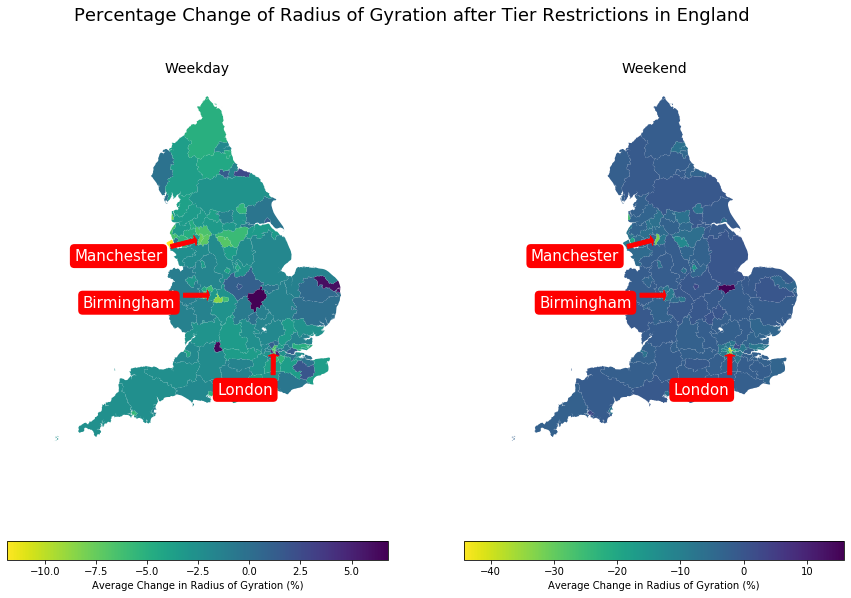

In [59]:
#plot weekend
cmap_reversed = plt.cm.get_cmap('viridis_r')


fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#gdf_NUTS3_results_manlan = gdf_NUTS3_results_manlan.set_geometry('geometry')

ax1.set_axis_off()
ax2.set_axis_off()


gdf_NUTS3_results_manlan_rg.plot(linewidth=0, ax=ax1, column = 'wednesday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})
gdf_NUTS3_results_manlan_rg.plot(linewidth=0, ax=ax2, column = 'sunday_change', cmap=cmap_reversed,edgecolor='0',
                       legend = True,legend_kwds={'label': "Average Change in Radius of Gyration (%)",'orientation': "horizontal"})



ax1.set_title('Weekday',fontsize = 14)
ax2.set_title('Weekend',fontsize = 14)

annotation3 = ax2.annotate('Manchester', xy=Manchester_coordinates,  xycoords='data',
            xytext=Manchester_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 4,headwidth=10,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation3.set_fontsize(15)
annotation3.set_color('white')

annotation6 = ax2.annotate('Birmingham', xy=Birmingham_coordinates,  xycoords='data',
            xytext=Birmingham_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 4,headwidth=10,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation6.set_fontsize(15)
annotation6.set_color('white')

annotation7 = ax2.annotate('London', xy=London_coordinates,  xycoords='data',
            xytext=London_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 4,headwidth=10,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation7.set_fontsize(15)
annotation7.set_color('white')



annotation3 = ax1.annotate('Manchester', xy=Manchester_coordinates,  xycoords='data',
            xytext=Manchester_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 4,headwidth=10,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation3.set_fontsize(15)
annotation3.set_color('white')

annotation6 = ax1.annotate('Birmingham', xy=Birmingham_coordinates,  xycoords='data',
            xytext=Birmingham_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 4,headwidth=10,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation6.set_fontsize(15)
annotation6.set_color('white')

annotation7 = ax1.annotate('London', xy=London_coordinates,  xycoords='data',
            xytext=London_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.10,width = 4,headwidth=10,headlength = 2,edgecolor='red'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': 'red', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation7.set_fontsize(15)
annotation7.set_color('white')



fig.suptitle('Percentage Change of Radius of Gyration after Tier Restrictions in England',fontsize = 18)
fig.savefig(root_figure+'/metropolitan'+'/england.pdf', dpi=fig.dpi,bbox_inches='tight')

